In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

In [2]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('C:/Users/deeks/Downloads/SentimentAnalysis Project/training.1600000.processed.noemoticon.csv/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
1316656,4,2014178884,Wed Jun 03 00:41:51 PDT 2009,NO_QUERY,dlsnax,@anggembay let's play!
727680,0,2262877358,Sat Jun 20 23:26:00 PDT 2009,NO_QUERY,coyotetoo,Not every day you watch someone get killed on ...
390254,0,2054634625,Sat Jun 06 07:46:31 PDT 2009,NO_QUERY,DWsRoseC,@nancyadoresjon @JKFalsettoKing we could have ...
985427,4,1834473853,Mon May 18 03:04:23 PDT 2009,NO_QUERY,Noni_x,Soo bored that it's not funny. I should be stu...
1129057,4,1975456861,Sat May 30 15:11:46 PDT 2009,NO_QUERY,DaWaBZ94,"@symbianguru but for sure, this makes e71 pref..."


In [3]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
print('length of data is', len(df))

length of data is 1600000


In [5]:
df.shape

(1600000, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
np.sum(df.isnull().any(axis=1))

0

In [8]:
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   6
Count of rows in the data is:   1600000


In [9]:
df['target'].unique()

array([0, 4], dtype=int64)

In [10]:
df['target'].nunique()

2

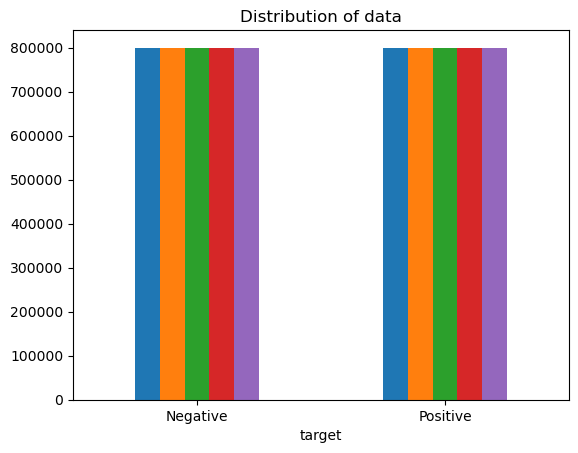

In [11]:
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
text, sentiment = list(df['text']), list(df['target'])

<Axes: xlabel='target', ylabel='count'>

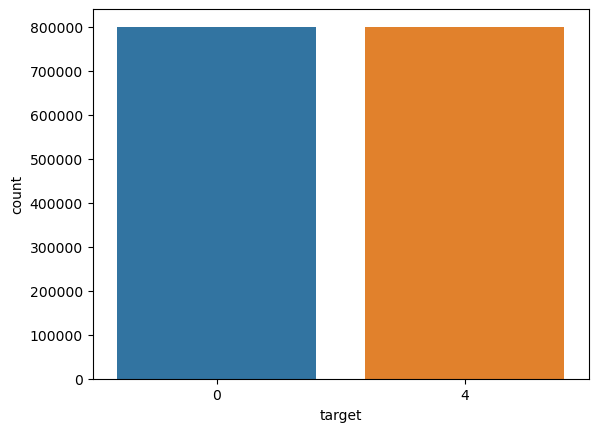

In [12]:
import seaborn as sns
sns.countplot(x='target', data=df)

In [13]:
data=df[['text','target']]

In [14]:
data['target'].unique()

array([0, 4], dtype=int64)

In [15]:
data_pos = data[data['target'] == 4]
data_neg = data[data['target'] == 0]

In [16]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [17]:
dataset = pd.concat([data_pos, data_neg])

In [18]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].head()

800000         i love @health4uandpets u guys r the best!! 
800001    im meeting up with one of my besties tonight! ...
800002    @darealsunisakim thanks for the twitter add, s...
800003    being sick can be really cheap when it hurts t...
800004      @lovesbrooklyn2 he has that effect on everyone 
Name: text, dtype: object

In [19]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
            's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [20]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [21]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].head()

800000                   love health4uandpets u guys r best
800001    im meeting one besties tonight cant wait  girl...
800002    darealsunisakim thanks twitter add sunisa got ...
800003    sick really cheap hurts much eat real food plu...
800004                       lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [22]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].head()

800000                   love health4uandpets u guys r best
800001    im meeting one besties tonight cant wait  girl...
800002    darealsunisakim thanks twitter add sunisa got ...
800003    sick really cheap hurts much eat real food plu...
800004                       lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [23]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [24]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [25]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [26]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [27]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [28]:
X=data.text
y=data.target

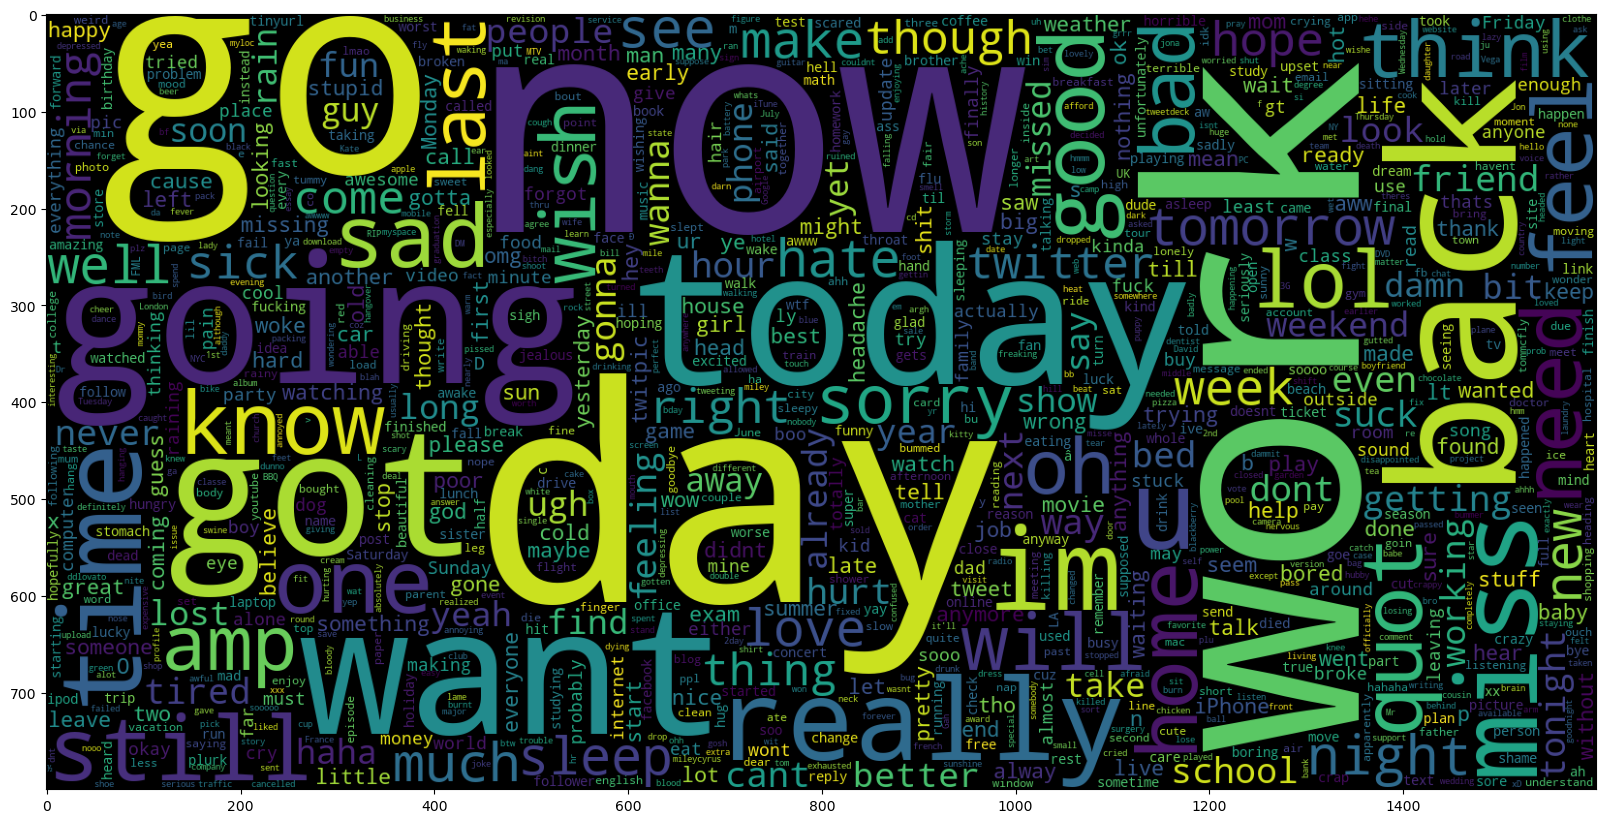

In [29]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

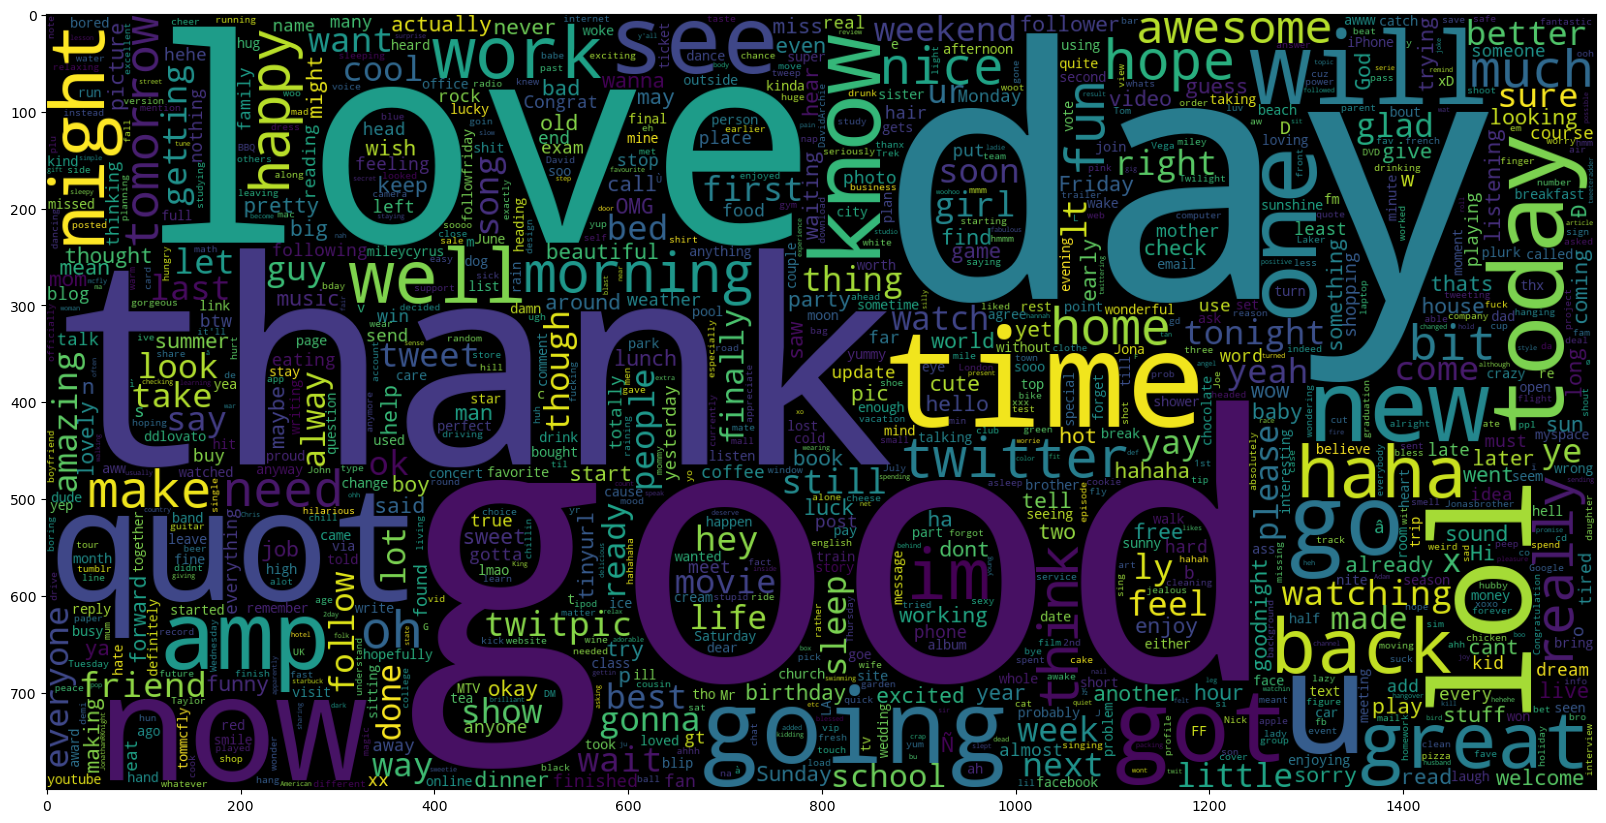

In [30]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

In [32]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

In [33]:
def model_Evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    cf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cf_matrix)

    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    print("Labels Array after reshape:\n", labels)
    sns.set(font_scale=1.4)
    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='', xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)
    plt.show()

    return y_pred

In [34]:
def roc_Curve(y_pred):
    y_test_binary = (y_test == 4).astype(int)
    fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.legend(loc="lower right")
    plt.show()

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     40100
           4       0.80      0.81      0.80     39900

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000

Confusion Matrix:
 [[31813  8287]
 [ 7649 32251]]
Labels Array after reshape:
 [['True Neg\n39.77%' 'False Pos\n10.36%']
 ['False Neg\n9.56%' 'True Pos\n40.31%']]


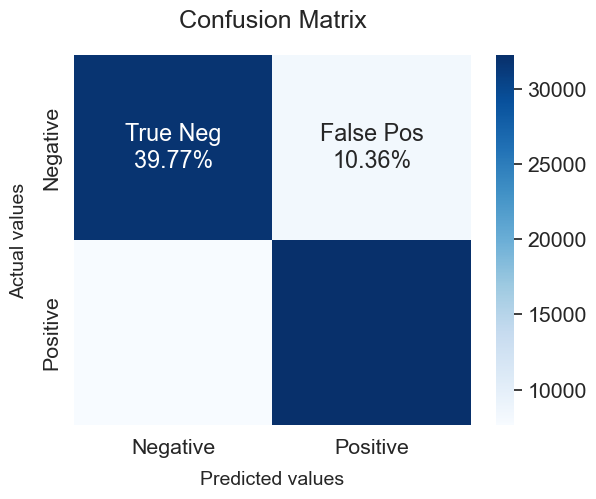

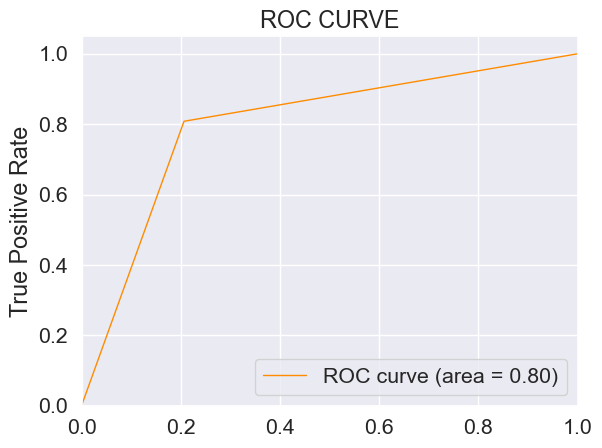

In [35]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train_transformed, y_train)
y_pred1 = model_Evaluate(BNBmodel, X_test_transformed, y_test)
roc_Curve(y_pred1)

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     40100
           4       0.81      0.82      0.82     39900

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000

Confusion Matrix:
 [[32395  7705]
 [ 7013 32887]]
Labels Array after reshape:
 [['True Neg\n40.49%' 'False Pos\n9.63%']
 ['False Neg\n8.77%' 'True Pos\n41.11%']]


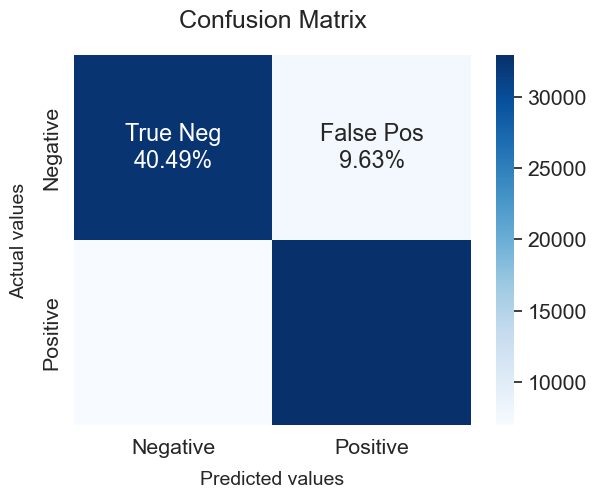

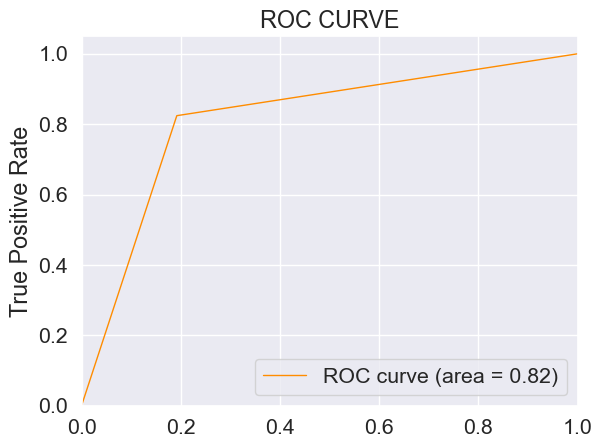

In [36]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train_transformed, y_train)
y_pred2 = model_Evaluate(SVCmodel, X_test_transformed, y_test)
roc_Curve(y_pred2)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     40100
           4       0.82      0.84      0.83     39900

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000

Confusion Matrix:
 [[32773  7327]
 [ 6567 33333]]
Labels Array after reshape:
 [['True Neg\n40.97%' 'False Pos\n9.16%']
 ['False Neg\n8.21%' 'True Pos\n41.67%']]


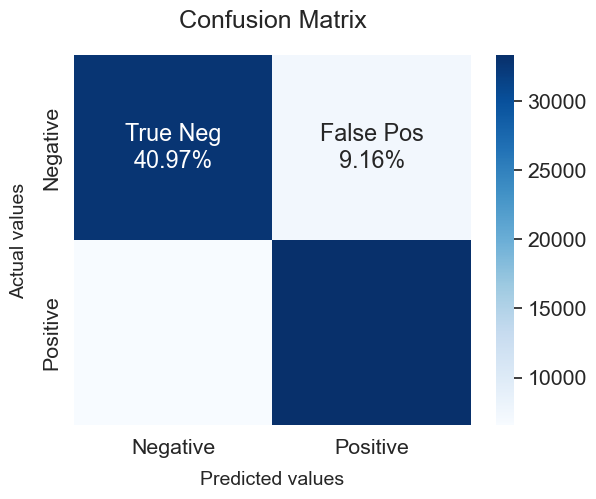

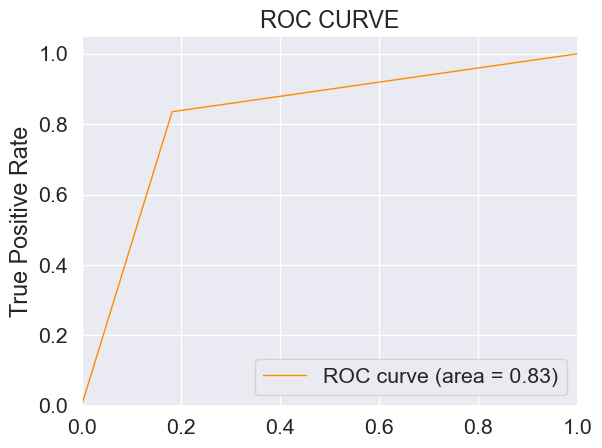

In [37]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train_transformed, y_train)
y_pred3 = model_Evaluate(LRmodel, X_test_transformed, y_test)
roc_Curve(y_pred3)